In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet as TFMobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define path
path = "/content/drive/MyDrive/Food Image Segmentation/My Food Dataset/"

In [ ]:
# Get subdirectories (excluding unwanted files)
listDir = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
listDir = sorted(listDir)

In [ ]:
# Function to load images and masks
def loadImg(path):
    input_img, mask_img = [], []

    # Directly specify the image and mask folders
    inpDir = os.path.join(path, "Image")
    maskDir = os.path.join(path, "Mask")

    imgDirs = sorted(os.listdir(inpDir))
    mask_imgDirs = sorted(os.listdir(maskDir))

    for imgFile in imgDirs:
        imgPath = os.path.join(inpDir, imgFile)
        img = load_img(imgPath, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        input_img.append(img)

    for maskFile in mask_imgDirs:
        maskPath = os.path.join(maskDir, maskFile)
        mask = load_img(maskPath, target_size=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img

In [ ]:
# Since images and masks are in one folder pair
input_imgs, mask_imgs = loadImg(path)
print(f"Total images loaded: {len(input_imgs)}")
print(f"Total masks loaded: {len(mask_imgs)}")

Total images loaded: 50
Total masks loaded: 50


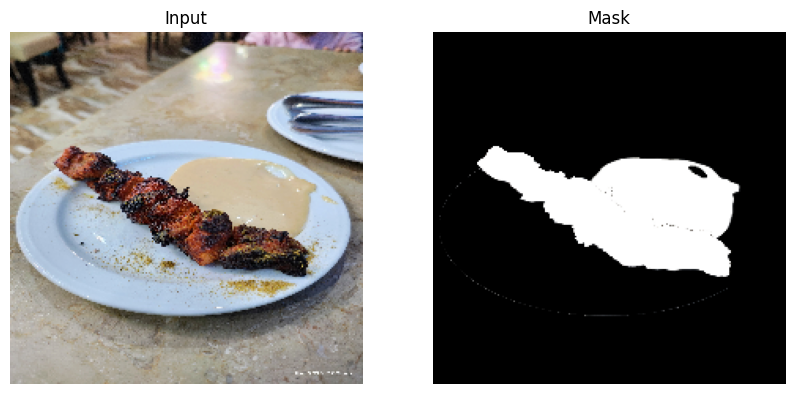

In [ ]:
# Visualize a sample
if input_imgs and mask_imgs:
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input")
    plt.imshow(input_imgs[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask_imgs[0], cmap="gray")
    plt.axis("off")

    plt.show()

In [ ]:
# Load input_imgs and mask_imgs
assert len(input_imgs) == len(mask_imgs), "Mismatch between images and masks."

In [ ]:
# Split dataset into training and validation sets
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    input_imgs, mask_imgs, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_imgs)}")
print(f"Validation images: {len(val_imgs)}")

Training images: 40
Validation images: 10


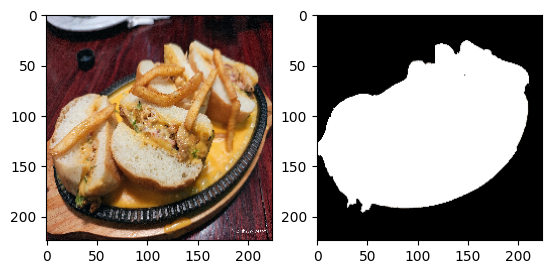

In [ ]:
# Visualize a set
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[1])

plt.subplot(1, 2, 2)
plt.imshow(train_masks[1])

In [ ]:
#Convolution and UpSampling
def Conv(x, dropout, filters):
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool

def UpSample(x, skip_connect, dropout, filters):
    x = Concatenate(axis=-1)([skip_connect, UpSampling2D(size=(2, 2))(x)])
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    return x

In [ ]:
#Defining model
def CustomMobileNet(input_shape=(224, 224, 3), dropout=0.1):
    # Load the MobileNet model as the encoder (pre-trained on ImageNet)
    mobilenet = TFMobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Extract intermediate feature maps
    conv1 = mobilenet.get_layer('conv_pw_1_relu').output
    conv2 = mobilenet.get_layer('conv_pw_3_relu').output
    conv3 = mobilenet.get_layer('conv_pw_5_relu').output
    conv4 = mobilenet.get_layer('conv_pw_11_relu').output
    bottleneck = mobilenet.get_layer('conv_pw_13_relu').output

    # Decoder
    conv5 = UpSample(bottleneck, conv4, dropout, 512)
    conv6 = UpSample(conv5, conv3, dropout, 256)
    conv7 = UpSample(conv6, conv2, dropout, 128)
    conv8 = UpSample(conv7, conv1, dropout, 64)

    # Final upsampling and segmentation output
    conv9 = UpSampling2D(size=(2, 2))(conv8)
    result = Conv2D(filters=3, kernel_size=1, activation='sigmoid', padding='same')(conv9)

    # Define the model
    model = Model(inputs=mobilenet.input, outputs=result)
    return model

In [ ]:
# Instantiate the model
input_shape = (224, 224, 3)
model = CustomMobileNet(input_shape=input_shape, dropout=0.1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 15,768,579 (60.15 MB)

 Trainable params: 15,744,771 (60.06 MB)

 Non-trainable params: 23,808 (93.00 KB)

In [ ]:
# Compile model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Train model
history = model.fit(
    np.array(train_imgs),
    np.array(train_masks),
    batch_size=8,
    epochs=10,
    validation_data=(np.array(val_imgs), np.array(val_masks))
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.3987 - loss: 0.6660 - val_accuracy: 0.9670 - val_loss: 61.1049
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.3560 - loss: 0.1923 - val_accuracy: 0.2093 - val_loss: 5.9343
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.1712 - loss: 0.1415 - val_accuracy: 0.5655 - val_loss: 4.3244
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 11s/step - accuracy: 0.1940 - loss: 0.1131 - val_accuracy: 0.4948 - val_loss: 6.4844
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 11s/step - accuracy: 0.3480 - loss: 0.1022 - val_accuracy: 0.5295 - val_loss: 2.8249
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 14s/step - accuracy: 0.4050 - loss: 0.0848 - val_accuracy: 0.3871 - val_loss: 2.3411
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 11s/step - accuracy: 0.3394 - loss: 0.0729 - val_accuracy: 0.6453 - val_loss: 1.2007
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.2877 - loss: 0.0752 - val_accuracy: 0.4869 - val_loss: 0.9644

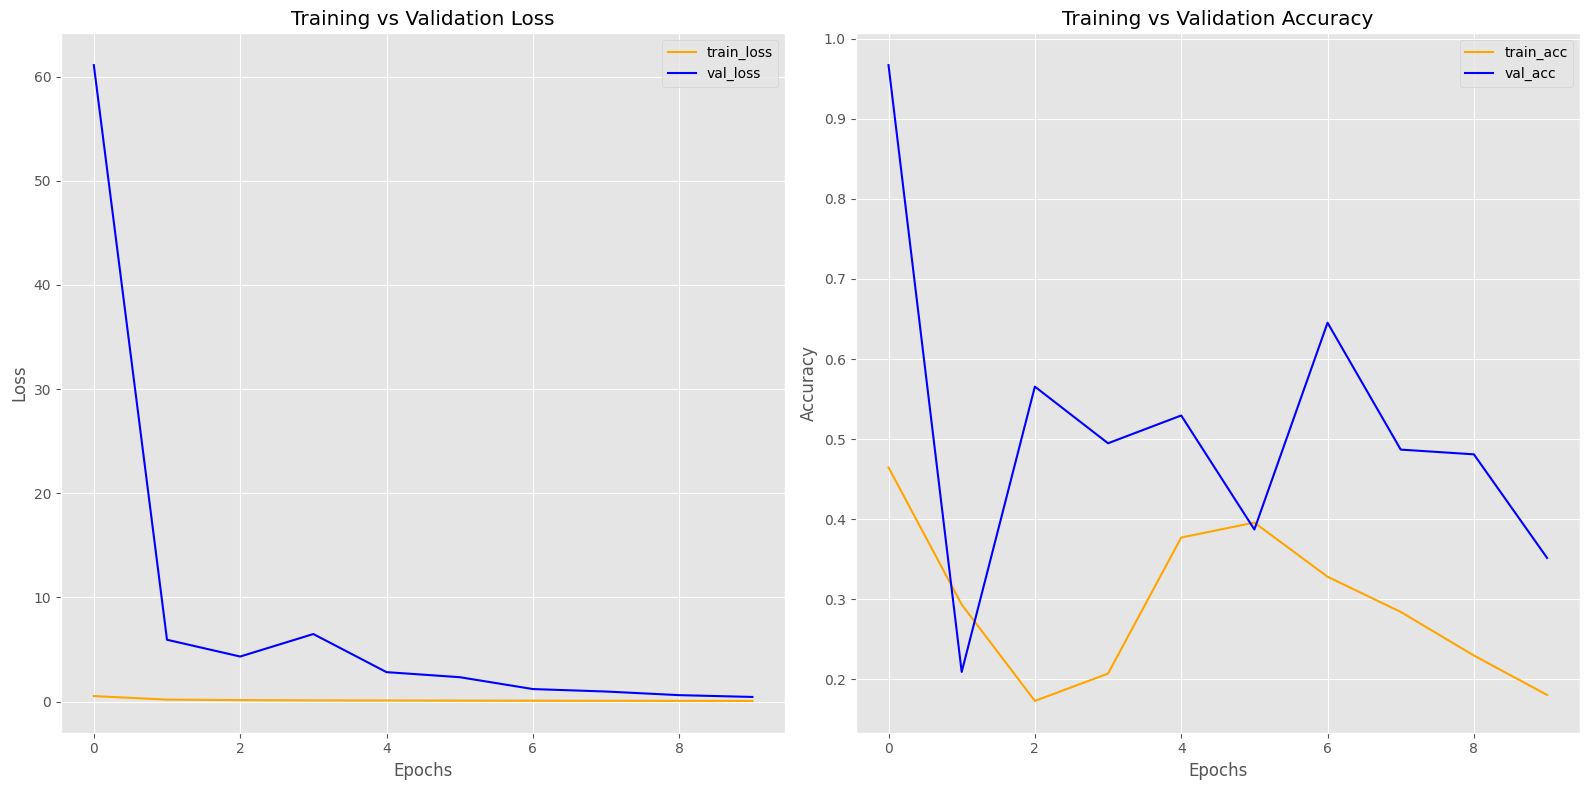

In [ ]:
# Set the style once
plt.style.use('ggplot')

# Create a figure with two subplots
plt.figure(figsize=(16, 8))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], c='orange', label='train_loss')
plt.plot(history.history['val_loss'], c='blue', label='val_loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], c='orange', label='train_acc')
plt.plot(history.history['val_accuracy'], c='blue', label='val_acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


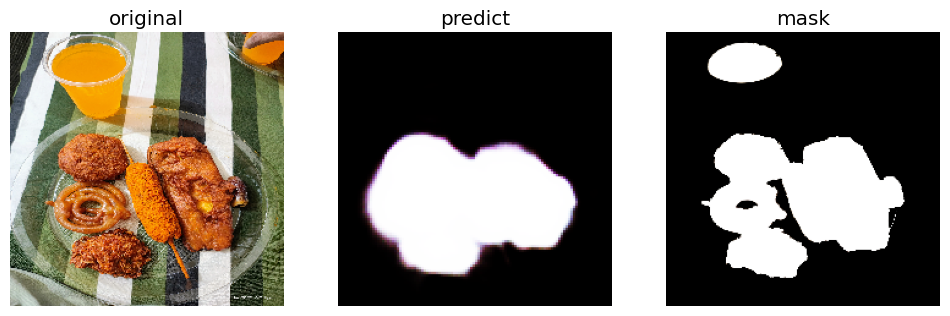

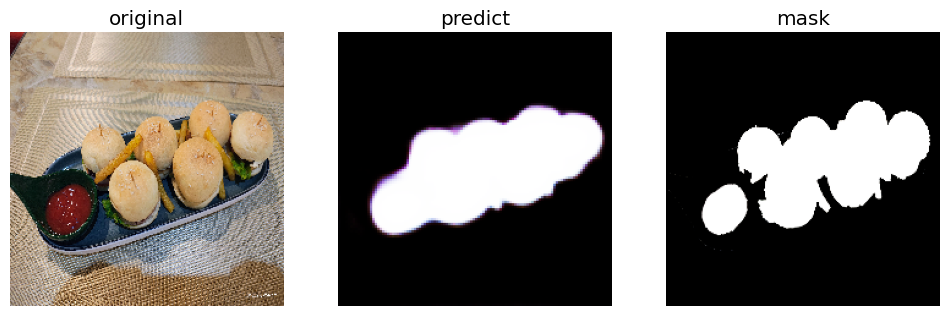

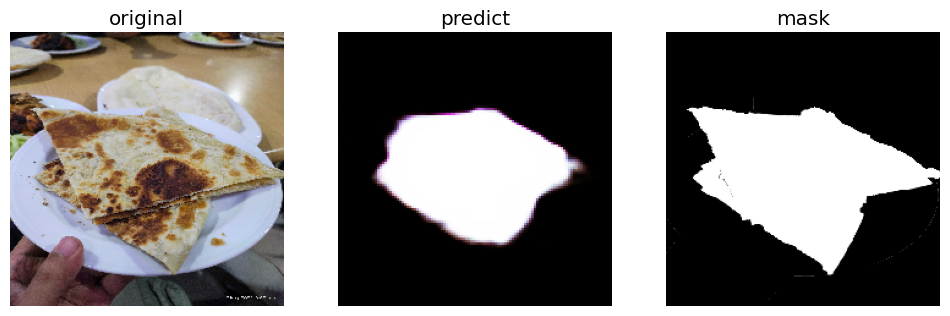

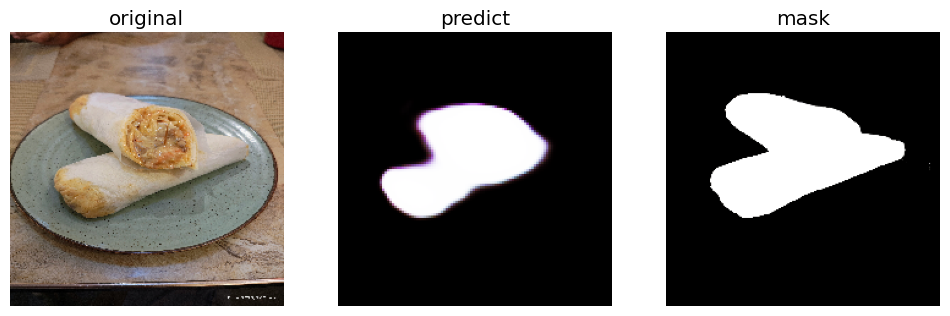

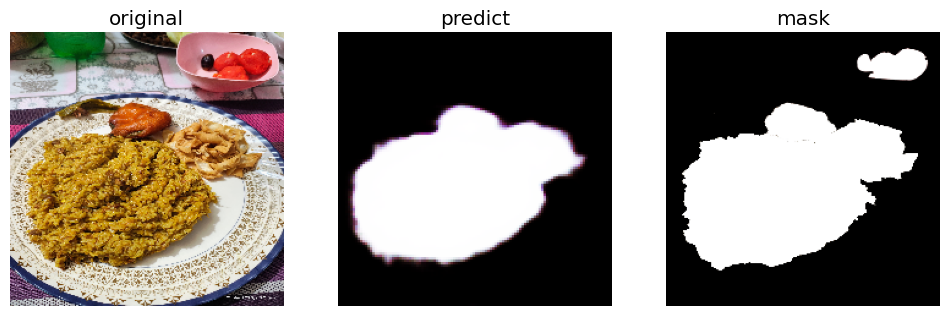

In [ ]:
#Final result
images_predict = model.predict(np.array(val_imgs))
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (12, 7))

    ax[0].set_title('original')
    ax[0].imshow(val_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('mask')
    ax[2].imshow(val_masks[id])
    ax[2].axis("off")

for id in range(5):
    show_result(id)